In [19]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re


nltk.download('stopwords')
nltk.download('punkt')

df = pd.read_csv('./mining/reddit_clean.csv')
df['text'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')

df = df[df['created_utc'] >= 1677654056]

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Removing stopwords, special characters and applying stemming & lemmatization
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [word.lower() for word in words if word.lower() not in stop_words]
    words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

new_df = df.copy()

new_df['clean_text'] = df['text'].apply(preprocess_text)
new_df['token_count'] = new_df['clean_text'].apply(lambda x: len(x.split()))
print(len(new_df))
new_df = new_df[new_df['token_count'] >= 10]
print(len(new_df))

# Compute similarity matrix and remove highly similar rows
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(new_df['clean_text'])
cosine_sim = cosine_similarity(tfidf_matrix)

threshold = 0.95  # You can adjust this value based on your preference
to_drop = set()

for i in range(len(new_df)):
    for j in range(i+1, len(new_df)):
        if cosine_sim[i][j] > threshold:
            to_drop.add(j)

new_df = new_df.drop(new_df.index[list(to_drop)])

print(len(new_df))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alirezaarvandi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alirezaarvandi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2552
1793
1615


/Users/alirezaarvandi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


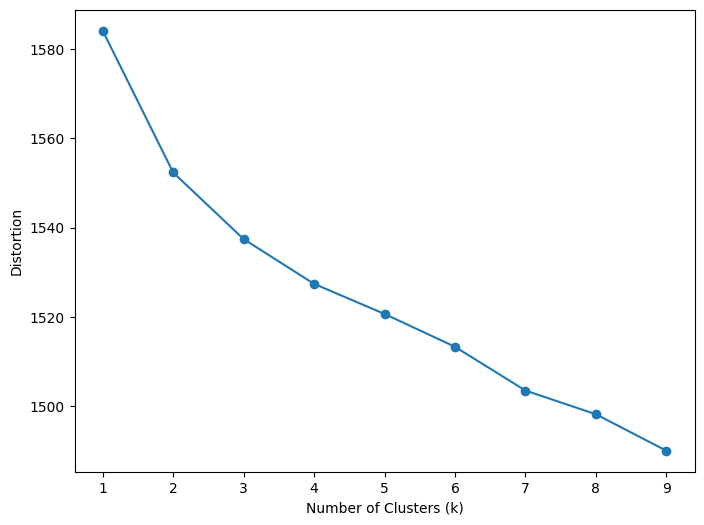

In [20]:
# Clustering using k-means tf-idf

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


# Step 1: Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(new_df['clean_text'])

# Step 2: Apply Elbow Method to find the optimal number of clusters
distortions = []
K_range = range(1, 10)  # Change the range based on your dataset

for k in K_range:
    km = KMeans(n_clusters=k)
    km.fit(X)
    distortions.append(km.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.show()

In [21]:
optimal_k = 4

# Step 3: Perform K-means clustering with the optimal number of clusters
km = KMeans(n_clusters=optimal_k)
km.fit(X)

# Add cluster labels to the original DataFrame
new_df['cluster_label'] = km.labels_
distances = km.transform(X)

# For each data point, select the distance to its cluster
new_df['cluster_dist'] = [distances[i][new_df['cluster_label'].iloc[i]] for i in range(len(new_df))]

/Users/alirezaarvandi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


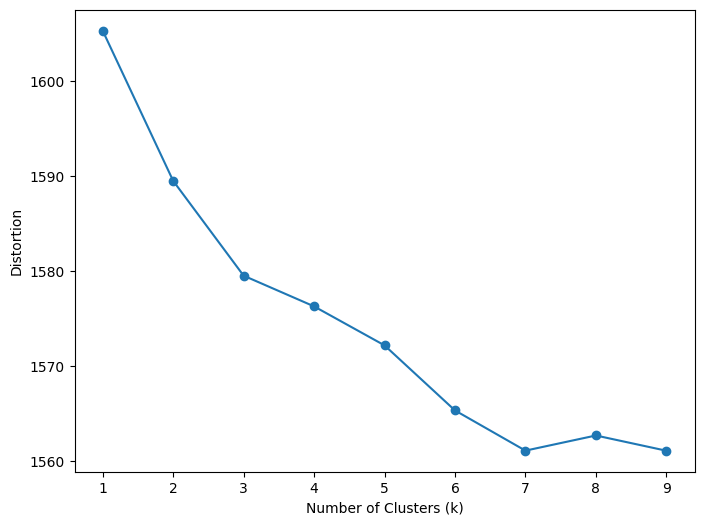

In [22]:
# Clustering using k-means with n-grams

import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Assuming the necessary preprocessing tools are already imported
# e.g., stop_words, stemmer, lemmatizer

# Removing stopwords, special characters and applying stemming & lemmatization
# def preprocess_text(text):
#     text = re.sub(r'[^\w\s]', '', text)
#     words = text.split()
#     words = [word.lower() for word in words if word.lower() not in stop_words]
#     words = [stemmer.stem(word) for word in words]
#     words = [lemmatizer.lemmatize(word) for word in words]
#     return ' '.join(words)

# new_df = df.copy()

# new_df['clean_text'] = df['text'].apply(preprocess_text)
# new_df['token_count'] = new_df['clean_text'].apply(lambda x: len(x.split()))
# print(len(new_df))
# new_df = new_df[new_df['token_count'] >= 5]
# print(len(new_df))

# Step 1: Text Vectorization using TF-IDF with n-grams
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3)) # Using unigrams and bigrams
X = vectorizer.fit_transform(new_df['clean_text'])

# Step 2: Apply Elbow Method to find the optimal number of clusters
distortions = []
K_range = range(1, 10)  # Change the range based on your dataset

for k in K_range:
    km = KMeans(n_clusters=k)
    km.fit(X)
    distortions.append(km.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.show()

In [23]:
optimal_k = 4

# Step 3: Perform K-means clustering with the optimal number of clusters
km = KMeans(n_clusters=optimal_k)
km.fit(X)

# Add cluster labels to the original DataFrame
new_df['cluster_label_n_gram'] = km.labels_
distances = km.transform(X)

# For each data point, select the distance to its cluster
new_df['cluster_dist_n_gram'] = [distances[i][new_df['cluster_label_n_gram'].iloc[i]] for i in range(len(new_df))]

In [24]:
new_df.columns
from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(new_df['cluster_label'], new_df['cluster_label_n_gram'])
print(f"Adjusted Rand Index between cluster_label and cluster_label_n_gram: {ari_score:.2f}")

ct = pd.crosstab(new_df['cluster_label'], new_df['cluster_label_n_gram'])

print(ct)

Adjusted Rand Index between cluster_label and cluster_label_n_gram: 0.69
cluster_label_n_gram     0    1   2    3
cluster_label                           
0                        4  123   0    0
1                      138   11   0  183
2                        0   21  19   43
3                     1068    0   0    5


In [25]:
from collections import Counter

def top_keywords(texts, num=5):
    # Combine all the texts into a single string and tokenize the string into words
    all_words = ' '.join(texts).lower()
    all_words = re.findall(r'\w+', all_words)  # Tokenize words
    all_words = [word for word in all_words if word not in stop_words and len(word) > 2 and word.isalpha()]
    counter = Counter(all_words)
    
    # Return the most common words
    return counter.most_common(num)


for label in range(4):
    print(f"Top 5 rows for Cluster {label}:")
    subset = new_df[new_df['cluster_label'] == label]
    sorted_subset = subset.sort_values(by='cluster_dist', ascending=True).head(5)
    for i in sorted_subset['text']:
        print(i)
    keywords = top_keywords(subset['text'])
    print("Top 5 keywords:", [word[0] for word in keywords])
    print("\n")

for label in range(4):
    print(f"Top 5 rows for Cluster {label}:")
    subset = new_df[new_df['cluster_label_n_gram'] == label]
    sorted_subset = subset.sort_values(by='cluster_dist', ascending=True).head(5)
    for i in sorted_subset['text']:
        print(i)
    keywords = top_keywords(subset['text'])
    print("Top 5 keywords:", [word[0] for word in keywords])
    print("\n")

Top 5 rows for Cluster 0:
wildfire near williams lake being actioned by bc wildfire services - williams lake tribune - williams lake tribune  
two areas west of quesnel on evacuation alert due to wildfires - williams lake tribune - williams lake tribune  
wildfire burning in the chilcotin west of williams lake april 27 - williams lake tribune - williams lake tribune  
williams lake has a new firessmart coordinator - williams lake tribune - williams lake tribune  
gusty winds, downed power line sparks wildfire at riske creek west of williams lake - williams lake tribune - williams lake tribune  
Top 5 keywords: ['lake', 'williams', 'tribune', 'wildfire', 'fire']


Top 5 rows for Cluster 1:
new wildfire in b.c.'s central interior sparks evacuation order in parts of cariboo - bc news - castanet.net  
wildfire near williams lake considered under control by bc wildfire services - coast mountain news - coast mountain news  
evacuation order issued for new wildfire burning near quesnel and wi